# Model evaluation

This notebook will:
* Look closer on the data and predictions

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt

Pick the name for your model

In [2]:
model_name = 'ANN_M1'

## Load model and data

In [3]:
data = pds.read_pickle(model_name + '.pkl')
data.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,tsjs,journey,segment_time
641,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
642,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
643,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
644,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
645,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0


In [4]:
# Load YAML and create model
yaml_file = open(model_name + '.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights(model_name + '.h5')

Model needs to be compiled again

In [5]:
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
None


Divide into labels and data, note that `journey` needs to be removed as well!

In [6]:
test_labels = data['segment_time']
test_input = data.drop('segment_time', axis=1)
test_data = test_input.drop('journey', axis=1)
test_input.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,tsjs,journey
641,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2
642,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2
643,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2
644,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2
645,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2


General model evaluation

In [7]:
model.evaluate(test_data.values, test_labels.values)

598562/598562 [==============================] - 5s 8us/step


[16.859156629768925, 16.859156629768925]

## Start by looking at an entire journey

In [8]:
journeys = test_input.journey.unique()

Pick out a random journey

In [9]:
selected_journey = np.random.choice(journeys)
to_test = test_input[test_input['journey'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

870/870 [==============================] - 0s 209us/step


In [10]:
journey_ = test_input.index[test_input['journey'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

First plot

In [11]:
# Set window size, only needed once
plt.rcParams['figure.figsize'] = [16, 11]

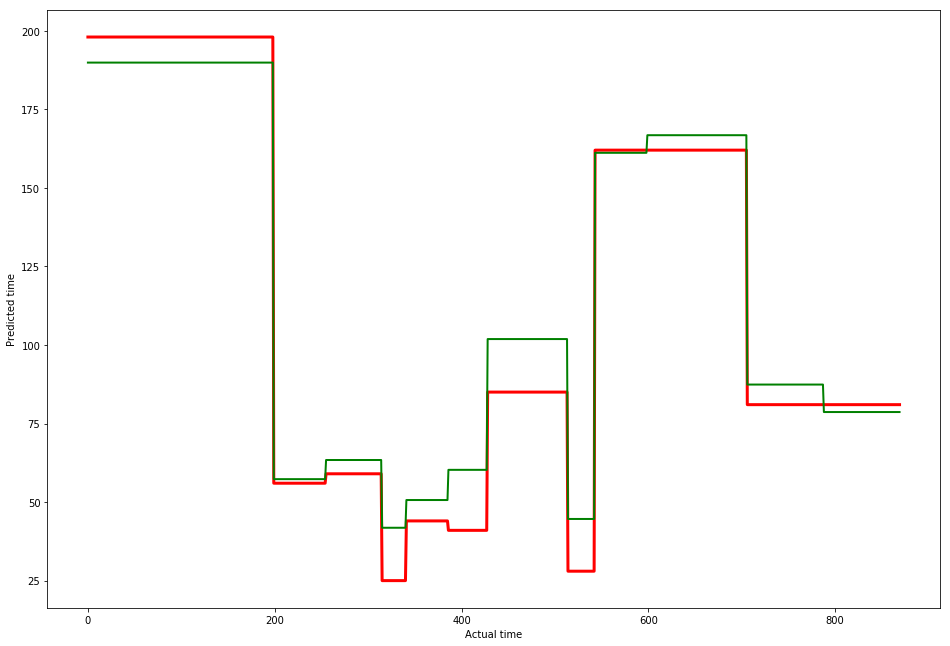

870/870 [==============================] - 0s 14us/step
MAE: [7.709324228900602, 7.709324228900602]


In [12]:
plt.plot(j_labels, color='red', linewidth=3, markersize=12)
if 'speed' in model_to_predict.columns:
    plt.scatter(range(len(predictions)),predictions, c=model_to_predict['speed'].values)
    plt.colorbar()
else:
    plt.plot(predictions, color='green', linewidth=2, markersize=12)
    
plt.ylabel('Predicted time')
plt.xlabel('Actual time')
plt.show()
print('MAE:', model.evaluate(model_to_predict.values, j_labels.values))

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time. This does not seem to apply to model M1 though!

Also, the color is normalized speed (0-1)

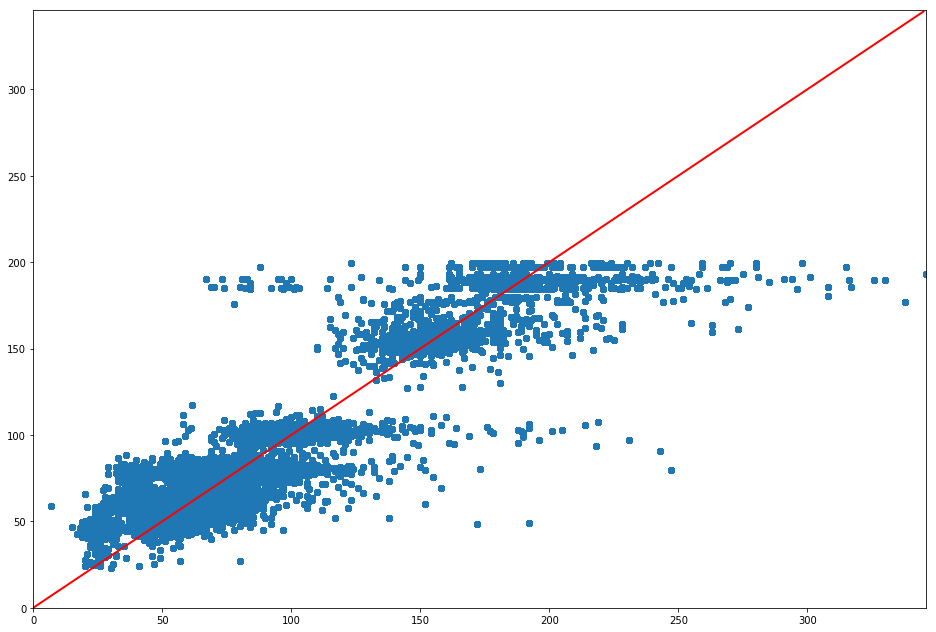

In [13]:
test_predictions = model.predict(test_data.values)
color = None
if 'speed' in test_data.columns:
    color = test_data['speed'].values
plt.scatter(test_labels.values, test_predictions, c=color)
max_time = np.int_(np.round(np.append(np.transpose(test_labels.values), test_predictions).max()))
plt.xlim(0, max_time)
plt.ylim(0, max_time)
plt.plot(range(max_time),range(max_time), color='red', linewidth=2)
plt.show()

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [14]:
# Drop first segment, all journeys
test_ign = test_data[test_data[1] == 0].index
test_ign_d = test_data.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

# Drop first segment, single journey

# Selected_journey from previous section is used to compare loss
test_single_j = test_input[test_input['journey'] == selected_journey]
to_test = test_single_j.drop(columns=['journey'])

test_single = to_test[to_test[1] == 0].index
test_single_d = to_test.loc[test_single]

journey_ = test_labels[test_input['journey'] == selected_journey]
test_single_l = journey_.loc[test_single]
test_single_l = test_single_l.reset_index().drop(columns=['index'])

Evaluate model on all data

In [15]:
model.evaluate(test_ign_d.values, test_ign_l.values)

473939/473939 [==============================] - 4s 8us/step


[14.985615321112741, 14.985615321112741]

In general, alla models benefit from removing the first segment. There is probably a lot of dwell time at the start of the segment.

In [16]:
predictions_ = model.predict(test_single_d.values, batch_size=1, verbose=1)

671/671 [==============================] - 0s 179us/step


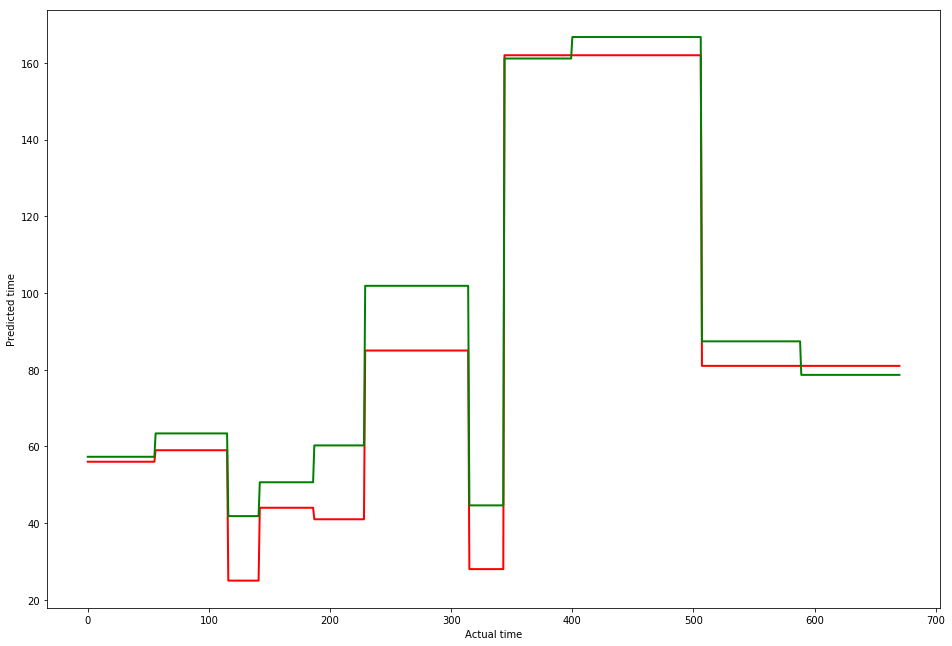

671/671 [==============================] - 0s 13us/step
MAE: [7.582086498797739, 7.582086498797739]


In [17]:
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
if 'speed' in model_to_predict.columns:
    plt.scatter(range(len(predictions_)),predictions_, c=model_to_predict['speed'].values)
    plt.colorbar()
else:
    plt.plot(predictions_, color='green', linewidth=2, markersize=12)

plt.ylabel('Predicted time')
plt.xlabel('Actual time')
plt.show()
print('MAE:', model.evaluate(test_single_d.values, test_single_l.values))

## Now, lets look only at segment 9 (McD to Gamla Linköping for line 3)

In [18]:
# Select segment 9 for all journeys
test_ign = test_input[test_input[9] == 1].index
test_ign_d = test_input.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

In [19]:
eval_data = []
eval_labels = []

for i, seg in test_ign_d.groupby('journey'):
    n_seg = seg.drop(columns=['journey'])
    n_idx = n_seg.index
    pred = model.predict(n_seg, verbose=0)
    eval_data.append([pred])
    eval_labels.append([test_ign_l.loc[n_idx].reset_index().drop(columns=['index'])])

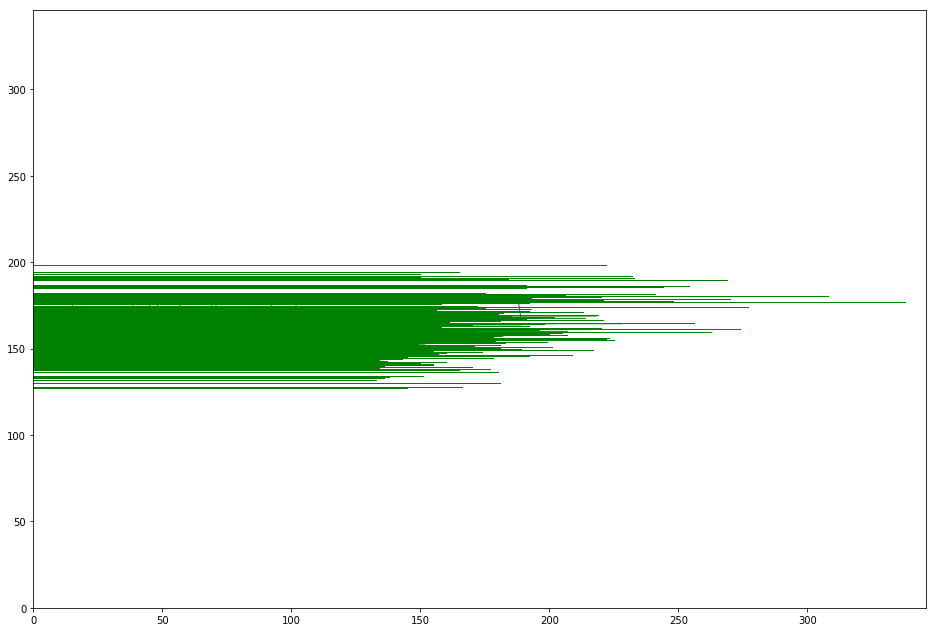

In [22]:
for i in range(len(eval_data)):
    plt.plot(eval_data[i][0], color='green', linewidth=1, markersize=2)
    #plt.plot(eval_labels[i][0], color='red', linewidth=2, markersize=12)
    
plt.xlim(0, max_time)
plt.ylim(0, max_time)
plt.show()

For bus line 3:

There seems to be large variance in this segment. This is the segment containing Vallarondellen, which is known for having large traffic issues during rush hours. This is probably why some journeys are very far to the right and the actual travel time ranges from 100-350 seconds.